<font color='#660066'>

# NUFORC Reports

<font color='#660066'>
   
## Table of Contents

- [Data](#Data)
    - [Scraping from NUFORC](#Scraping-from-NUFORC)
    - [Loading Data](#Loading-data)
    - [Cleaing Data](#Cleaning)
- [Analysis](#Analysis)
    - [Time of Occurrence](#Time-of-occurrence)
        - [Can the reports be explained?](#Can-the-reports-be-explained?)
        - [A bias of memory](#A-bias-of-memory)
        - [Other spikes](#Other-spikes)
        - [Final Conclusions about time](#Final-Conclusions-about-time)
    - [Location of the occurrence](#Location-of-the-occurrence)
        - [UFO Reports per States](#UFO-Reports-per-States)
        - [UFO Reports per Capita](#UFO-Reports-per-Capita)
    - [What emotions are prevalent in the report?](#What-emotions-are-prevalent-in-the-report?)
- [Basic anlayis](#Basic-Anylsis)
- [Milestone 3](#milestones)
- [Miscellaneous](#Miscellaneous)
    - [Wordcloud of popular words](#Wordcloud-of-popular-words)
    - [References](#References)

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import lib.scraping as scraping
import lib.postprocessing_and_plotting as post
import lib.sentiment as sentiment
import lib.cleaning as clean
import lib.nuforc_analysis as nuforc
import lib.image_scraping as img_scrape
import lib.maps as maps
import lib.image_processing as img_proc
from ipywidgets import interact, IntSlider, fixed

data_folder = "data/"
file_url_list = data_folder + 'full_list_of_urls.json'
report_file = 'all_sightings.csv'

<font color='#660066'>

# Data

## Scraping from NUFORC


The National UFO Reporting Center (**NUFORC**) lists reports splitted by the occured date, by posting date, by shape or by location. These sightings has been collected since 1974. NUFORC provides a [Hotline](http://www.nuforc.org/Report.html) or [web formular]() to submit the UFO encounters. These reports are checked for hoax and fake reports, according to [several reports](https://www.reddit.com/r/UFOs/comments/6h5jfc/nuforc_filters_their_reports_much_better_than/). The sightings also include articles from news papers and historical accounts.

We decided to scrape the data from their web page using the *request* and *beatifulsoup* libraries. 

The first step to fetch all the possible shapes and then we can fetch all the urls from each of the shape. 



In [ ]:
all_shapes = scraping.fetch_shape_urls()
all_reporting_urls = scraping.fetch_all_sighting_urls(all_shapes)

<font color='#660066'>

Let's see how many shapes and reportings there are: 

In [28]:
print("Number of shapes:", len(all_shapes))
print("Nubmer of sighting:", len(all_reporting_urls))

Number of shapes: 31
Nubmer of sighting: 117722


<font color='#660066'>

We don't want to constantly send requests to the server, therefore store the file in urls in a json file. 

In [29]:
scraping.store_to_json(all_reporting_urls, file_url_list)

# import href list of each report
with open(file_url_list) as train_file:
    href_data = json.load(train_file)
urls_to_read = href_data['url']['0']

<font color='#660066'>

Now we are ready to fetch all the reports and convert it to a Pandas DataFrame.

In [ ]:
%%time
df_reports = scraping.build_report_dataframe(urls_to_read)
df_reports.to_json(data_folder + "all_sightings.json")

<font color='#660066'>

The whole scraping process took more than 1 hour. 

<font color='#660066'>
    
## Loading data

Of course we dont want so scrape every time so we load the file. The initial data contains the following columns: 
- Occurred
- Reported
- Posted
- Location
- Shape
- Duration
- Summary

In [2]:
df_reports = pd.read_csv(data_folder+report_file)
df_reports.sample(2).head()

,Unnamed: 0,Duration,Location,Occurred,Posted,Reported,Shape,Summary,url
71572,58533,10 minutes,"Kearns, UT",12/3/2012 19:15 (Entered as : 12/03/12 19:15),12/20/2012,12/3/2012 7:17:10 PM 19:17,Light,Oberserved multiple orange ascending upwards a...,http://www.nuforc.org/webreports/094/S94943.html
2719,102443,approx 2 min,"Chicago, IL",7/23/2011 23:47 (Entered as : 7-23-11 23:47),8/7/2011,7/24/2011 12:18:29 AM 00:18,Triangle,Three orange-red lights in shape of triangle w...,http://www.nuforc.org/webreports/082/S82687.html


<font color='#660066'>
    
## Cleaning

These are reports which were not fetched correctly, we have to investigate further why these are missing. <br>
Let's see how many are not fetched:

In [3]:
not_found_reports = df_reports[pd.isnull(df_reports.Summary)]
print("Not found reports", not_found_reports.count()['url'])

Not found reports 106


<font color='#660066'>

#### A
- The function below does post processing on the scraped data such as cleaning whitespace, renaming the columns, ordering the columns and applies filters so that we only retrieve the desired data wich contains summary data and sufficient information for the states.
- In our dataset we noticed there are several emtpy strings. We decided exchange these empty strings with NaN for easier parsing. 

#### B
- split all NUFORC notes of each summary into a seperate column 
- split all links of each summary into a seperate column

#### C
- Seperate MADAR notes into seperate Dataframe

In [4]:
print("cleaning..")
df_reports, df_madar_reports = clean.clean_data(df_reports)
print("..done")

cleaning..
..done


<font color='#660066'>

#### After Cleaning the data our structure looks like this

In [5]:
df_reports.sample(2)

,Duration,Location,State,Occurred,Posted,Reported,Shape,Summary,nuforc_note,link
url,,,,,,,,,,
http://www.nuforc.org/webreports/136/S136114.html,NaN,Long Beach,CA,2017-09-09 18:12:00,9/12/2017,2017-09-10 21:22:00,Circle,"Immobile, white dot, not shiny and appeared to...",[],[]
http://www.nuforc.org/webreports/047/S47449.html,7.5,Suffolk,VA,1984-07-25 20:00:00,11/8/2005,2005-11-04 20:03:00,Sphere,"Large, orangey colored sphere rose slowly from...",[((NUFORC Note: Witness indicates that the da...,[]


<font color='#660066'>
    
# Analysis
    
## Time of occurrence

<font color='#660066'>

### Can the reports be explained?

A reports submission splits into three parts, 'Occurred' when the UFO sighting was noticed, 'Reported' when the sighting was reported to the NUFORC and 'Posted' when the actual report was published online.

The report with the oldest occurrence time is from 1762 which is a report from a [London newspaper](http://www.nuforc.org/webreports/050/S50113.html).

As pandas datetime deals with only years starting from 1900 and there would be very little reliability with reports so old, we will be looking into reports only starting from 1900.

Our goal is to understand if we can explain the results through specific events, like rocket launches, seasonal weather analysis, etc.

Thus we show the amount of reports occuring  per each month over our time period.

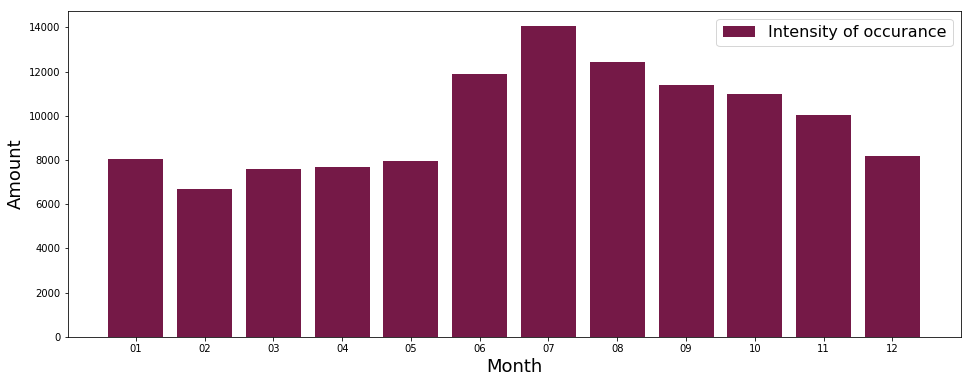

In [9]:
post.peaks_over_months(df_reports)

<font color='#660066'>


This plot shows the amount of reported occurances per month from 1900-2018.
We can see a very clear trend that during the summer months when there is an increase in submitted reports.
This can be reasoned with very logicaly, because during warmer periods people tend to spend more time outside, thus have a higher probability of making a sighting of a UFO.

<font color='#660066'>

But we see a clear increase in July, thus we will be investigating this month more, by plotting the reports from July over the time frame 1900 to 2018.

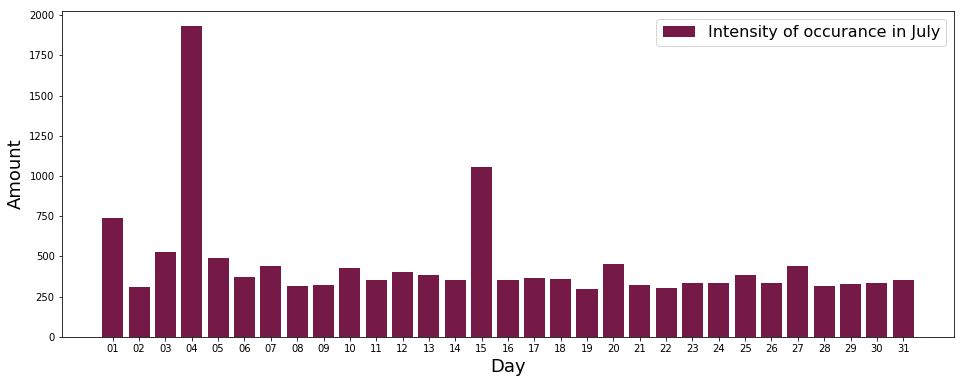

In [11]:
post.get_plot_july(df_reports)

<font color='#660066'>


### A bias of memory

Now, here things start to become very interesting. We can quite obviously see an increase for the 4th of July, as a lot of sightings might be connected with the fireworks in the US. 

Though, another very clear increase is on the 15th of July, but after a google query, no specific occurance in the month of July was found. Thus, an investigation of the 15th of July over the years occurs. What is more interesting, is that the increase on the 15th day of the month can be seen across multiple months.

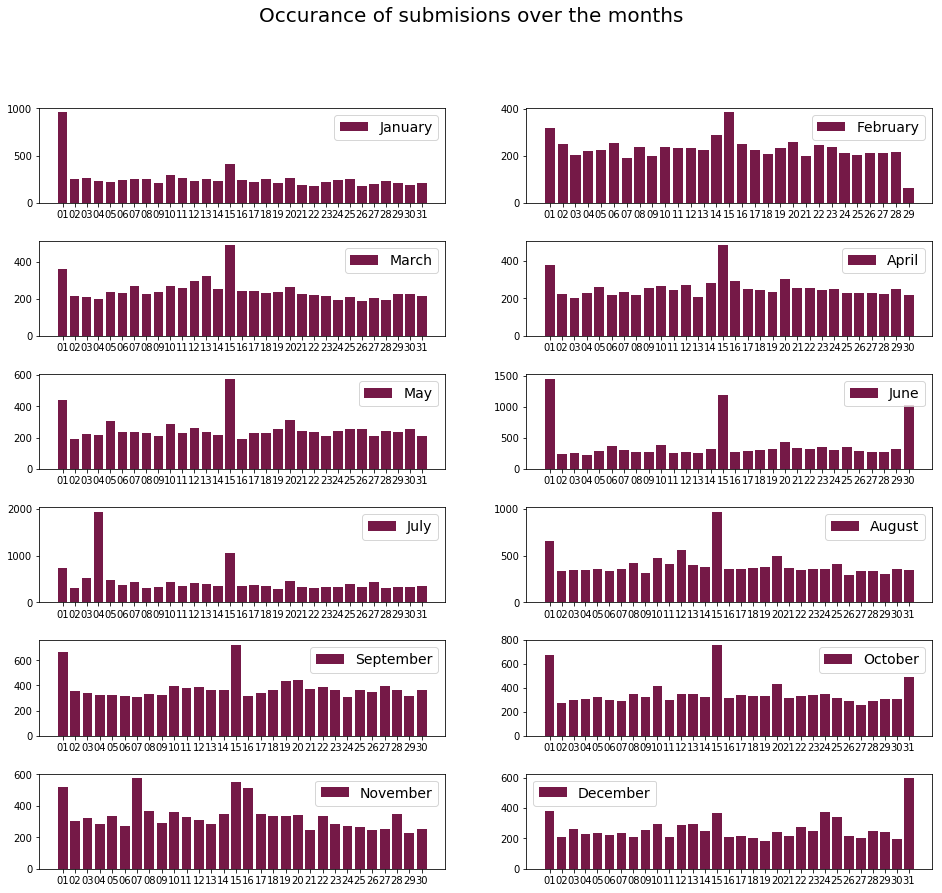

In [12]:
post.plot_for_each_month(post.get_data_for_months(df_reports))

<font color='#660066'>


We can see a very clear trend across all months, that during the 15th day of the month there is a sudden increase in occured reportings of UFOs. Also, in most months there is a peak on the first day of the month and in some on the last one. And in some months there are also other peaks, which most of the time can be explained due to holidays, such as the 4th of July of New Years Eve, when fireworks are very prevalent.

To get a better understanding of the peaks that occur in the middle of the month, we will plot the time difference between the Occurrence and Reporting of the sighting over days of the month.

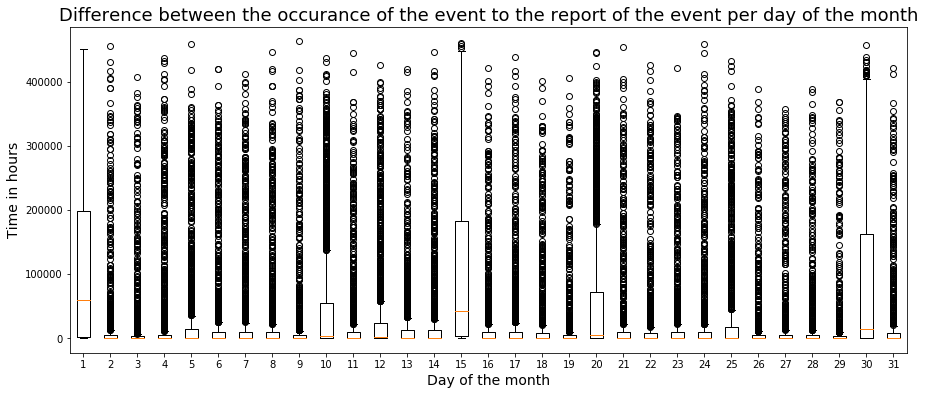

In [13]:
post.plot_occur_report_difference(post.occurance_report_difference(df_reports))

<font color='#660066'>


We see that we have some suspicious dates, where the mean is higher than for the other ones, these days fall on 'round' numbers, thus we propose that these dates are artificially inflated. In other words, UFO reporters which submit their reports after a longer time will have a bias towards round dates, which has been shown in previous research as well [1].

To test this further we will do Kolmogorov-Smirnov test on these dates to see if their empirical distribution matches the distribution of the other dates.

Thus we split our data into two subsets, one which consists of the 'suspicious' (1st day of the month and the days when day//5==0) and the other days.

In [14]:
data_all_days, data_suspicios_days = post.get_distribution_data(post.occurance_report_difference(df_reports))
post.kolmogorov_smirnov(data_all_days, data_suspicios_days)

Kolmogorov_Smirnov Statistic 0.30862854553990543 and p-value 0.0


True

<font color='#660066'>
    
#### Conclusions from statistics

By doing the Kolmogorov-Smirnov test we check wether these two datasets are of the same empirical distribution. As the p-value is below 0.05 we can reject the null hypothesis, meaning, that they are not of the same distribution. This further means, that reporters have a certain bias towards round dates after a long time between the occurance of the sighting and the reporting itself.

<font color='#660066'>
    
### Other spikes

The previous analysis only covers spikes, which are create themselves due to the bias of reporters. Thus, it is not an explanation per say of the reports, but of the reason why they aggragate at these specific dates.

To look more in depth in special cases/other peaks, we are plotting intensity of occurrence over the period 2004-2007 for all the months.

In [15]:
interact(post.spike_finder, year = IntSlider(min=2004,max=2007,step=1,value=2004),
                                              month = IntSlider(min=1,max=12,step=1,value=1),
                                                df = fixed(df_reports))

interactive(children=(IntSlider(value=2004, description='year', max=2007, min=2004), IntSlider(value=1, descri…

<function lib.postprocessing_and_plotting.spike_finder(year, month, df)>

<font color='#660066'>

#### From 2004 to 2007

After some manual searching for the peaks we found reasons for some of them, while other were reported in the news as UFOs as well.

15th April 2004, Florida sightings connected with rocket launch https://en.wikipedia.org/wiki/List_of_Atlas_launches_(2000%E2%80%932009)

26th June 2004, space debris entering atmosphere

21st august 2004 and 31st october 2004, 30th September 2005, https://www.youtube.com/watch?v=UE_hpI5K8fY, almost all reports over the same time, in the same location https://en.wikipedia.org/wiki/Black_triangle_(UFO)

31st August 2004, the missile launch https://www.space.com/299-mystery-cloud-appears-eastern-canada.html

29th of April 2005, titan IV misile launch https://en.wikipedia.org/wiki/Titan_IV

15th of May 2005, reports from all over the place, reports mention different shapes and sizes, no seemind connection with weather or anything else.

29th April 2006, a lot of reports from Portaland, Oregon, reports describe similar to that of this https://en.wikipedia.org/wiki/Black_triangle_(UFO)

1st of October 2006, reports from Colorado and New Mexico, no seeming correlation to meteorite showers or weather.

28th of November 2006, often described as fireball, possible explanation meteor event https://www.amsmeteors.org/members/imo_view/event/2006/448

16th of December 2006, possible explanation: meteor event https://www.amsmeteors.org/members/imo_view/event/2006/492

19-20th of June 2007, possible explanation, ISS docking of a cargo ship https://twitter.com/shuttlealmanac/status/744654510778245121

12th of August 2007, meteor shower at the time http://m.esa.int/Our_Activities/Space_Science/First_glimpses_from_the_Perseid_meteor_shower, though a lot of reports mention that they saw UFO within the meteor shower.

12th of December 2007, Atlas rocket fuel dump https://britastro.org/node/5886

<font color='#660066'>
    
### Final Conclusions about time

By manually checking the days of the peaks we could find reasonable explanations for most of them, such as rocket launches, space station fueling missions, meteorites, etc. But at the same time some peaks didn't leave any seeming correlation with events that could be explainable from earth/space weather or known human made flyers. For further analysis, one could track the locations of all the satellites over earths orbit (https://in-the-sky.org/satmap_worldmap.php) and cross check that with reports, which might match a description. For even deeper analysis, one could cross check all of the dates with astronomical calendars to possibly dispatch of even more reports. 

But in the end it would be impossible to explain all of the sightings, because often times reporters which want to believe in something, will make far fetched correlations for their beliefs, just to reinforce them.

Myyyyysterious, maybe UFO? ( or maybe call me )

<font color='#660066'>


## Location of the occurrence

### UFO Reports per States
#### not normalized by population


<font color='#660066'>

As most of the reportings are from the US, we are showing the distribution of reports from the different states. <br />
The data is not normalized at the moment.

In [ ]:
maps.sightings_per_state(df_ufo_reports)

<font color='#660066'>

### UFO Reports per Capita
##### Sightings per 100k people per state


In [ ]:
maps.sightings_per_state_normalized(df_ufo_reports)

<font color='#660066'>

### Shape

<font color='#660066'>

The shapes feature consist of 31 different shapes, with the most populated being a 'light source'.

In [ ]:
#df_every_thing = post.replace_empty_with_nan(df_every_thing, 'Shape')

<font color='#660066'>
    
### Duration

<font color='#660066'>

The duration is a user created data format, with lots of different formats, thus the cleaning and parsing of this data will take a large effort.

In [ ]:
#df_every_thing = post.replace_empty_with_nan(df_every_thing, 'Duration')

<font color='#660066'>

### Summary

<font color='#660066'>

User made input as the summary about the witnessed UFO sighting of varying length. 

In [ ]:
#df_every_thing = post.replace_empty_with_nan(df_every_thing, 'Shape')

<font color='#660066'>
<div class="alert alert-warning">
    
   <h3> Extracting and requesting pictures linked in reports </h3> 
   
</div> 

### Image Scraping

 Scrape .jpg's <br>
 -> to Folder /img/jpg/

In [ ]:
img_scrape.scrape_any_images(df_ufo_reports,".jpg")

<font color='#660066'>

 Scrape Youtube Thumbnails and Video titles <br>
 -> to  Folder /img/yt/

In [ ]:
img_scrape.scrape_yt_images(df_ufo_reports)

<font color='#660066'>

### The big UFO picture
- fetch images (so far yt thumbnails)
- calculate color dominance using kmeans 
- calculate lumincance
- sort by luminosity
- plot as grid image

In [12]:
big_image, df_img = img_proc.plot_sorted_images()
df_img.head()

,color,img,lum
13,"[[1, 1, 1]]",<PIL.JpegImagePlugin.JpegImageFile image mode=...,1.000000
5,"[[1, 1, 1]]",<PIL.JpegImagePlugin.JpegImageFile image mode=...,1.000000
26,"[[4, 3, 3]]",<PIL.JpegImagePlugin.JpegImageFile image mode=...,1.800278
15,"[[4, 3, 3]]",<PIL.JpegImagePlugin.JpegImageFile image mode=...,1.800278
14,"[[4, 4, 4]]",<PIL.JpegImagePlugin.JpegImageFile image mode=...,2.000000


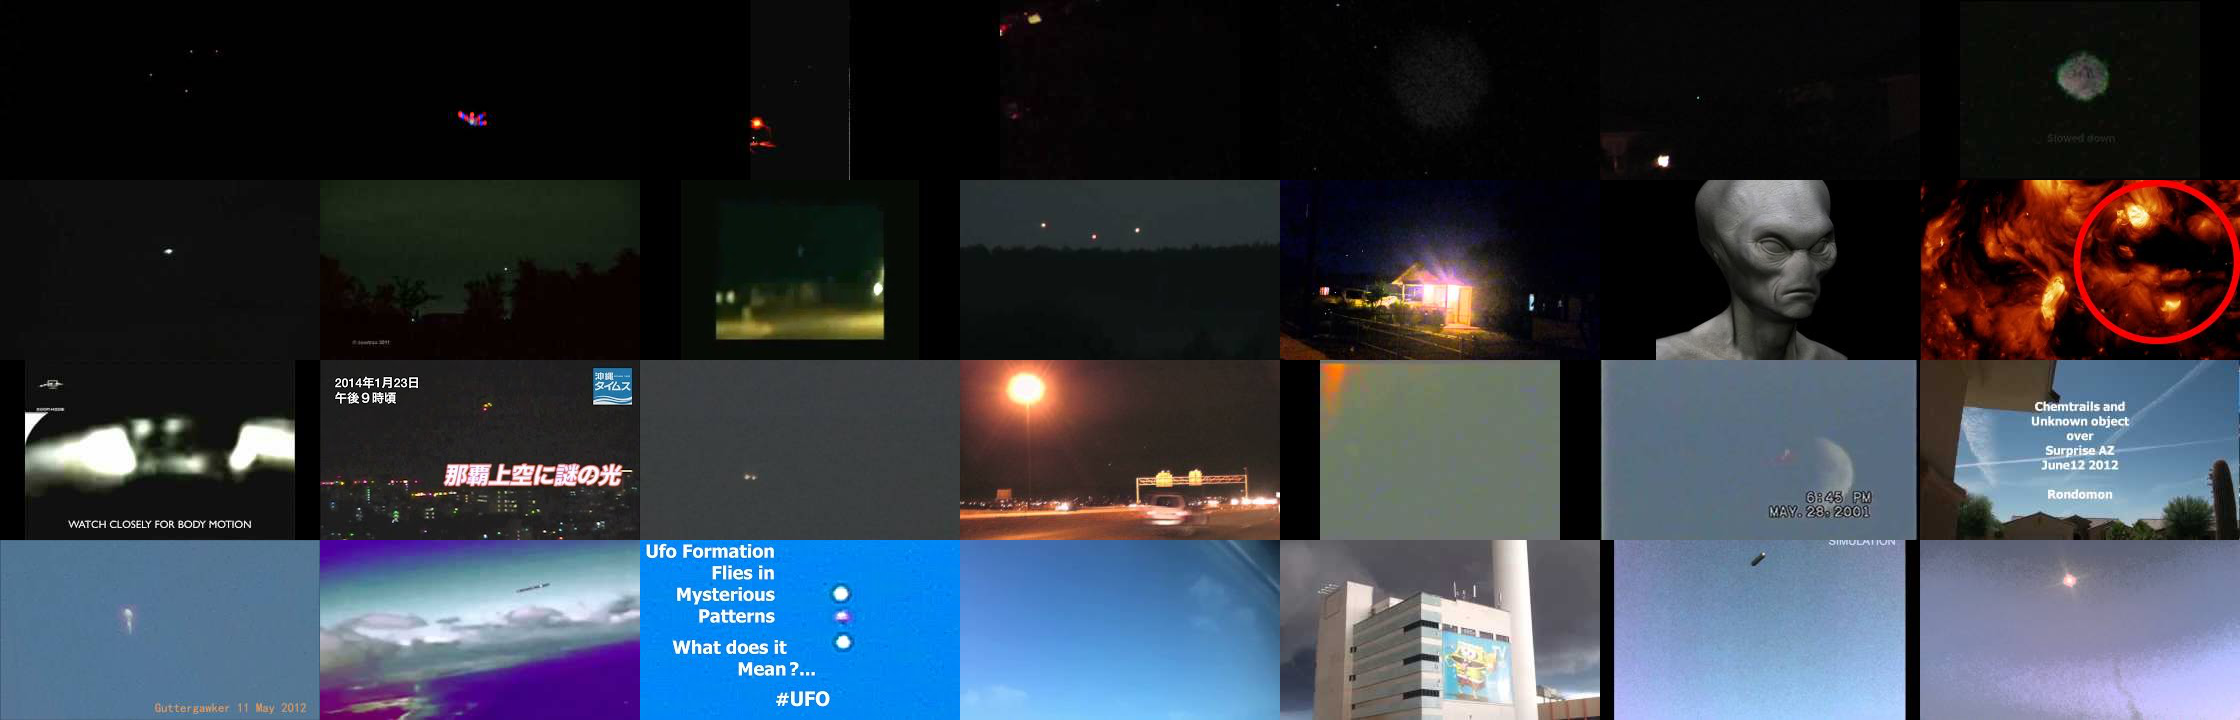

In [13]:
big_image

<font color='#660066'>

### NUFORC Note & Link Analysis

Distribution of NUFORC notes and links in the reports.

NUFORC
 0    78817
1    36165
2     2350
3       69
4        2
Name: nuforc_note, dtype: int64 

Links
 0    115358
1      1649
2       270
3        94
4        17
6         5
5         5
9         2
8         2
7         1
Name: link, dtype: int64


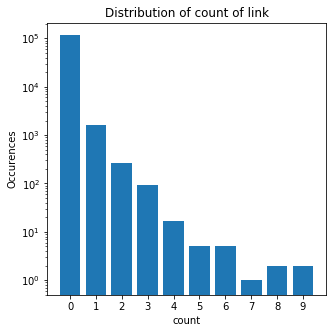

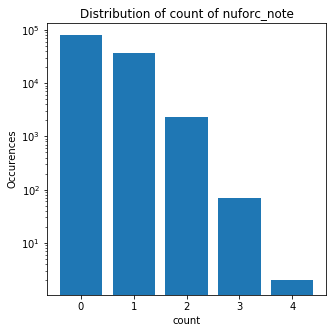

In [17]:
dist_nf_notes = nuforc.get_noforc_note_count_distribution(df_reports, "nuforc_note")
dist_links = nuforc.get_noforc_note_count_distribution(df_reports, "link")

print("NUFORC\n", dist_nf_notes, "\n\nLinks\n", dist_links)

nuforc.plot_distribution_of_notes(df_reports, "link")
nuforc.plot_distribution_of_notes(df_reports, "nuforc_note")

<font color='#660066'>

Filter all reports having n NUFORC Notes

In [19]:
res = nuforc.get_reports_having_n_elements(df_reports, 4, "link")
res.head(1)

,Duration,Location,State,Occurred,Posted,Reported,Shape,Summary,nuforc_note,link
url,,,,,,,,,,
http://www.nuforc.org/webreports/125/S125852.html,4.0,Cooleemee,NC,2016-02-05 20:00:00,2/19/2016,2016-02-14 12:35:00,Unknown,7 dark masses slowly fly past low above the tr...,[((NUFORC Note: Witness provides no contact i...,"[http://www.ncdc.noaa.gov.Climatological, http..."


<font color='#660066'>

# Sentiment Analysis


###  Getting sentiment


We use [LIBWC](http://liwc.wpengine.com/) to analyse the sentiment of each report. Since LIBWC does not provides an API, we have to export all reports as a text file first:

In [258]:
sentiment.export_alll_files(df_reports)

<font color='#660066'>
Now you have to run the sentiment anylsis for all the files we generated. This will produce a new file which we can now use.

In [6]:
df_report_sentiment = sentiment.add_sentiment_data(df_reports.reset_index())
df_report_sentiment.head(1)

,Duration,Location,State,Occurred,Posted,Reported,Shape,Summary,nuforc_note,link,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
url,,,,,,,,,,,,,,,,,,,,,
"(http://www.nuforc.org/webreports/086/S86976.html, http://www.nuforc.org/webreports/086/S86976.html)",12.5,Terre Haute,IN,2012-02-01 20:45:00,2/3/2012,2012-02-02 20:46:00,,jets investigate strange lighti was on my pati...,[],[],...,2.45,0.0,0.0,0.0,0.49,0.0,0.98,0.0,0.0,0.49


<font color='#660066'>
    

The [LIBWC2015](https://repositories.lib.utexas.edu/bitstream/handle/2152/31333/LIWC2015_LanguageManual.pdf) paper explains the emtions. For us interesting are the following columns:

- family
- friend
- sad 
- anger
- 'anx' for anxiety

<font color='#660066'>
    
### Word count

Before we analyze the senitment, let's analze the lenght of the reports:

In [7]:
df_report_sentiment.WC.describe(percentiles=[0.25, .5, .75, .9, .95]).to_frame()

,WC
count,117232.000000
mean,189.948504
std,192.333251
min,1.000000
25%,79.000000
50%,140.000000
75%,236.000000
90%,384.000000
95%,515.000000
max,11656.000000


<font color='#660066'>

We are not interested in reports largest 5% of the reports, therefore let's plot the distributaion of the rest:

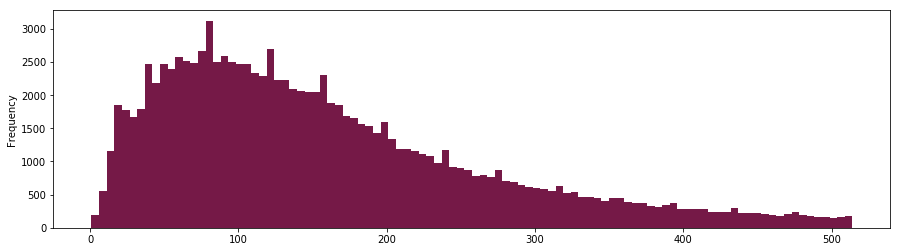

In [8]:
df_not_long_reports = df_report_sentiment[df_report_sentiment.WC < 515]
df_not_long_reports.WC.plot.hist(bins=100, figsize=(15, 4), color='#751947')


<font color='#660066'>
    
We can clearly

<font color='#660066'>

### Sentiment and Shape


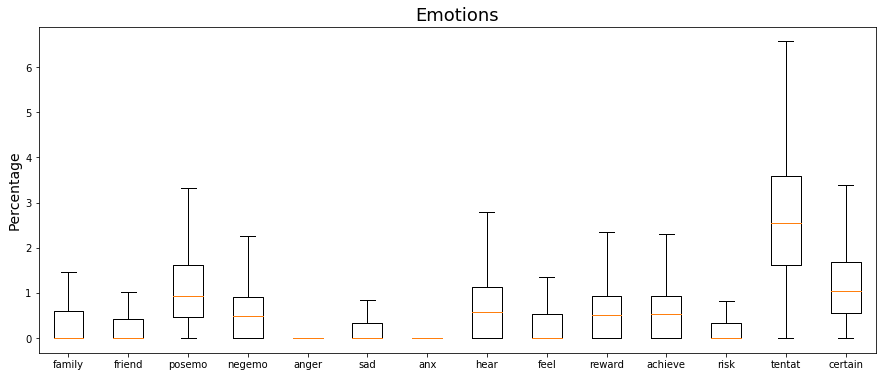

In [12]:
sentiment.emotions_boxplot(sentiment.get_emotion_data(df_report_sentiment), showfliers=False)

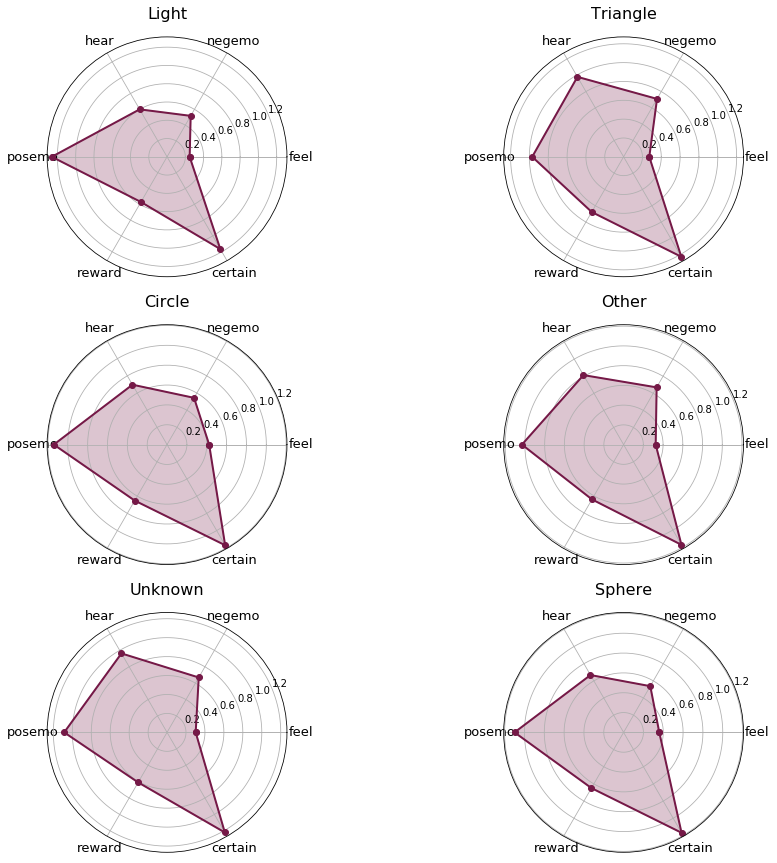

In [14]:
sentiment.plot_sentiment_nets(sentiment.get_emotion_data(df_report_sentiment))

<pre>

what  want to do for the next 30min:

    - get average of anger/sad/happy/family/friend per shape ( plot )
    - only reports above 100 WC ( this is some ranodm number, I've to figur out how many I drop like this)
    - 

''

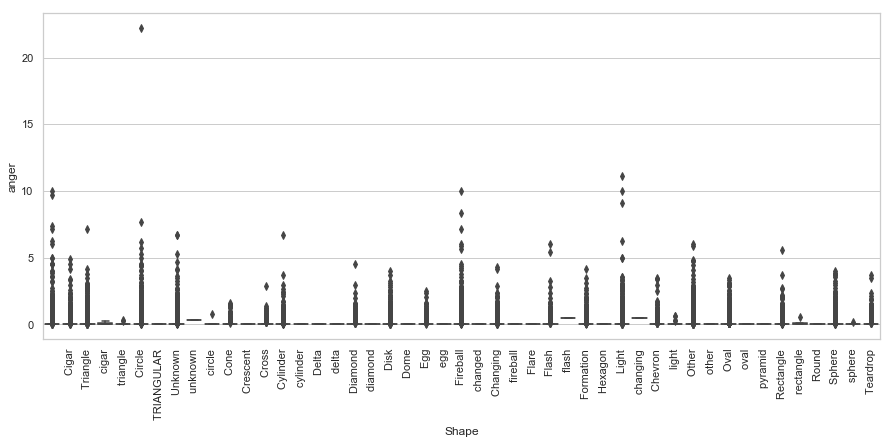

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(15, 6))
d = df_report_sentiment
ax = sns.boxplot(data=d, x='Shape', y='anger', ax=ax)
plt.xticks(rotation=90)
;
df_report_sentiment.head()
;

<font color='#660066'>
<div class="alert alert-danger">
    
   <h1> TODO </h1>
   
 </div>    

## Milestone 3

  

- Analyze words, keywords. 
- Read into sentiment analysis, to see if we can apply it to our case.
- Clean duration column
- Analyze if the people were at the time of the sighting
- Split NUFORC nodes
- Check for NUFORC generated HOAX messages
- Check out dem videos
- Keywords for sleep, dropping the reports which might have been dreams/sleep paralysis induced visions.
- Time of occurance/duration correlation
- Weather data (historic weather data, cloudy, sunny, storm, etc), general trends in US states (months with higher percipitation), sort the data by month and see which months have a higher rate of sightings (look in the years where there are the most sightings)
- Filter out MADAR data, see how much our dataset changes
- Analyze what shapes are associated with what feelings? 
- Analyze what shapes are consistently reported at same locations?

- Sentiment Analysis for summary text
    - start with vizualization of text
    ([inspiration](https://www.jasondavies.com/wordtree/?source=obama.inauguration.2013.txt&prefix=we%20must%20act))
- Correlation of weather and reports
- Analyze madar sensor data (also in correlation with weather)
- Create report results plots (webpage)
- todo: df_tst[df_tst["Summary"].str.contains("\(\(ADDENDUM")]


<font color='#660066'>
    
# Miscellaneous

<font color='#660066'>

## Wordcloud of popular words

We made wordclouds for each year starting at 1964 (which is the year from which there were more than 1000 reports), and found out the most popular shapes for these years. Over all the years the most popular shape was 'light', thus we decided to not include it in our further analysis, as well as the most popular words, as they would dominate the WordClouds and we couldn't get any interesting information out of them.

In [6]:
interact(post.generate_clipart, year = IntSlider(min=1964,max=2018,step=1,value=1998),
        frequency_years = fixed(post.get_data_for_wordclouds()))

interactive(children=(IntSlider(value=1998, description='year', max=2018, min=1964), Output()), _dom_classes=(…

<function lib.postprocessing_and_plotting.generate_clipart(year, frequency_years)>

<font color='#660066'>

## References

[1] Huttenlocher, J., Hedges, L. V., & Bradburn, N. M. (1990). Reports of Elapsed Time: Bounding and Rounding Processes in Estimation. _Journal of Experimental Psychology: Learning, Memory, and Cognition_, 16(2), 196-213. https://doi.org/10.1037/0278-7393.16.2.196